In [1]:
# Load library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
from datetime import datetime


In [2]:
# Load and preprocess data
df = pd.read_csv('3_benchmark_US.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df_filtered = df[df['DATE'] >= '1992-09-01']

# Select relevant columns and rename
plot_df = df_filtered[['DATE', 'Koop', 'ann_MLP', 'ann_LSTM', 'ann_XGB', 'ann_ENET']].copy()

model_labels = {
    "Koop": "Koop et al. (2023)",
    "ann_MLP": "MLP",
    "ann_LSTM": "LSTM",
    "ann_XGB": "XGB",
    "ann_ENET": "ENET"
}

# Melt the dataframe
melted_df = plot_df.melt(id_vars='DATE', var_name='Model', value_name='Value')

# Apply readable model labels AFTER melting
melted_df['Model'] = melted_df['Model'].map(model_labels)

# Define colors and line styles
model_colors = {
    "Koop et al. (2023)": "#000000",  # black
    "ENET": "#4D4D4D",                # gray30
    "LSTM": "#7F7F7F",                # gray50
    "MLP": "#999999",                 # gray60
    "XGB": "#B3B3B3"                  # gray70
}

model_linetypes = {
    "Koop et al. (2023)": "solid",
    "ENET": "solid",
    "LSTM": "dashed",
    "MLP": "dotted",
    "XGB": "dashdot"
}

/var/folders/1b/b3lsjhy10fsd753tw_292d5w0000gn/T/ipykernel_68153/3674081005.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE'] = pd.to_datetime(df['DATE'])


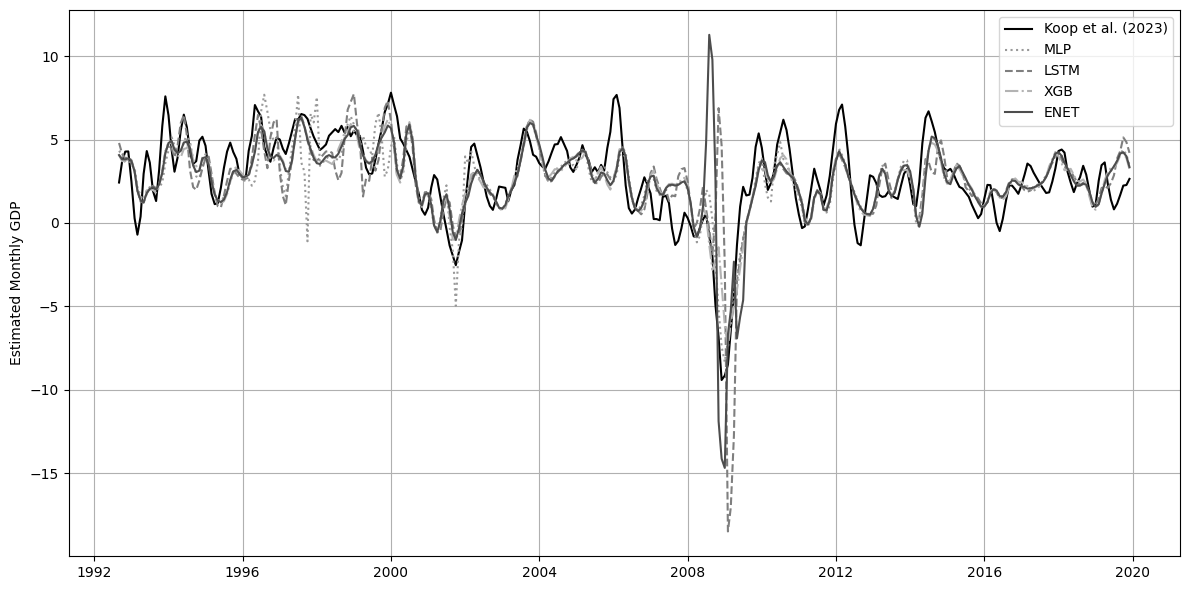

In [3]:
# Time Series Plot
plt.figure(figsize=(12, 6))
for model in melted_df['Model'].unique():
    temp_df = melted_df[melted_df['Model'] == model].dropna()
    plt.plot(temp_df['DATE'], temp_df['Value'],
             label=model,
             color=model_colors.get(model, '#888888'),
             linestyle=model_linetypes.get(model, 'solid'))

plt.ylabel("Estimated Monthly GDP")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("US_benchmark_1.pdf", bbox_inches='tight', dpi = 500)
plt.show()

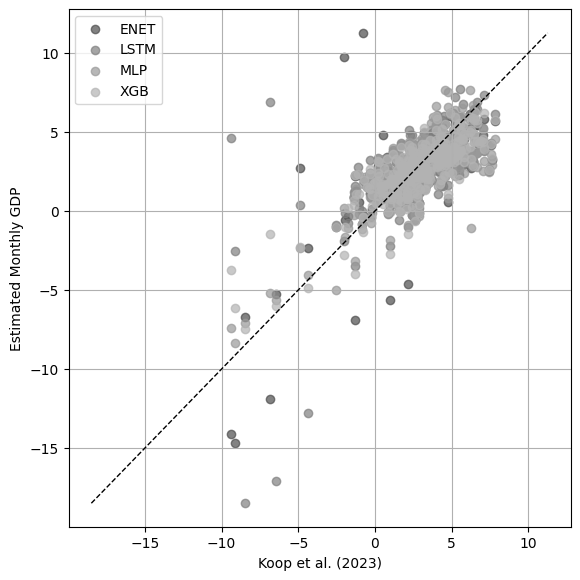

In [7]:
# Scatter Plot: Koop vs others
plot_df = plot_df.rename(columns={
    "Koop": "Koop et al. (2023)",
    "ann_MLP": "MLP",
    "ann_LSTM": "LSTM",
    "ann_XGB": "XGB",
    "ann_ENET": "ENET"
})

cm_to_inch = 1 / 2.54
figsize_in_inches = (15 * cm_to_inch, 15 * cm_to_inch)

plt.figure(figsize=figsize_in_inches)
for model in ['ENET', 'LSTM', 'MLP', 'XGB']:
    valid_df = plot_df[['Koop et al. (2023)', model]].dropna()
    plt.scatter(valid_df['Koop et al. (2023)'], valid_df[model],
                label=model,
                color=model_colors.get(model, '#888888'),
                alpha=0.7)

# 45-degree line
min_val = min(plot_df['Koop et al. (2023)'].min(), plot_df[['ENET', 'LSTM', 'MLP', 'XGB']].min().min())
max_val = max(plot_df['Koop et al. (2023)'].max(), plot_df[['ENET', 'LSTM', 'MLP', 'XGB']].max().max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1)

plt.xlabel("Koop et al. (2023)")
plt.ylabel("Estimated Monthly GDP")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save as 5cm × 5cm with high DPI
plt.savefig("US_benchmark_2.pdf", bbox_inches='tight', dpi=500)
plt.show()


In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

models = ['MLP', 'LSTM', 'XGB', 'ENET']
results = []

for model in models:
    valid = plot_df[['Koop et al. (2023)', model]].dropna()
    y_true = valid['Koop et al. (2023)']
    y_pred = valid[model]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    sign_acc = (np.sign(y_true) == np.sign(y_pred)).mean()

    results.append({
        'Model': model,
        'MAE': mae,
        'RMSE': rmse,
        'Correlation': corr,
        'Sign Accuracy': sign_acc
    })

results_df = pd.DataFrame(results)
print(results_df)


  Model       MAE      RMSE  Correlation  Sign Accuracy
0   MLP  1.269265  1.624071     0.772983       0.932927
1  LSTM  1.400687  2.126656     0.642294       0.923780
2   XGB  1.168031  1.503789     0.809799       0.932927
3  ENET  1.310758  1.917643     0.708096       0.926829


/var/folders/1b/b3lsjhy10fsd753tw_292d5w0000gn/T/ipykernel_39607/3892640336.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=melted_error_df, x='Model', y='Absolute Error', palette=model_colors)


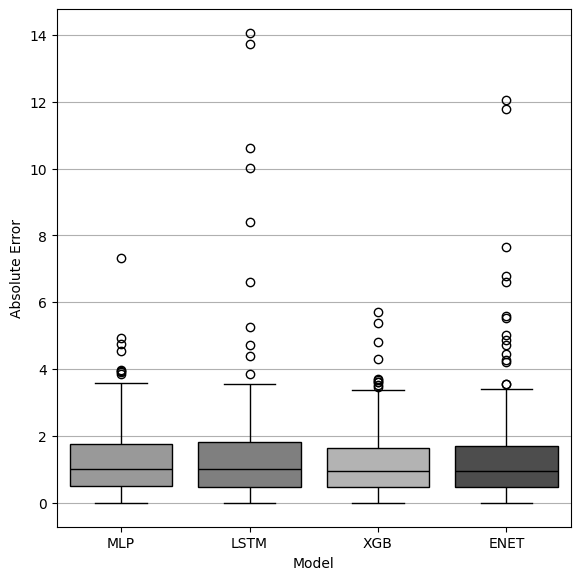

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute absolute error vs Koop
models = ['MLP', 'LSTM', 'XGB', 'ENET']
error_df = plot_df[['DATE', 'Koop et al. (2023)'] + models].copy()

for model in models:
    error_df[f'abs_error_{model}'] = abs(error_df['Koop et al. (2023)'] - error_df[model])

# Melt for plotting
melted_error_df = error_df.melt(
    id_vars='DATE',
    value_vars=[f'abs_error_{m}' for m in models],
    var_name='Model',
    value_name='Absolute Error'
)
melted_error_df['Model'] = melted_error_df['Model'].str.replace('abs_error_', '')

# 15cm x 15cm
plt.figure(figsize=(5.90551, 5.90551))
sns.boxplot(data=melted_error_df, x='Model', y='Absolute Error', palette=model_colors)

plt.ylabel("Absolute Error")
plt.xlabel("Model")
plt.grid(True, axis='y')
plt.tight_layout()

# Save to PDF with high quality
plt.savefig("US_benchmark_3.pdf", bbox_inches='tight', dpi=500)
plt.show()

